In [30]:
import pandas as pd

song_theme = pd.read_json('./Dataset/top_songs_lyrics.json')
song_theme.columns

Index(['year', 'artist', 'song', 'lyrics'], dtype='object')

# Latent Dirichlet Allocation (LDA) - 165 songs

**Three major ideas**
- Translate songs in native language to english
- pre-processing: Clean and tokenize the translated lyrics, remove stopwords (common and custom)
- Topic Modelling: Create an LDA model to identify topics within the song lyrics

**Detailed Steps**
1) Importing libraries
    - googletrans: handle text transaltion
    - string: provides constants for string manipulation 
    - nltk: A toolkit for natural language processing (NLP)
    - gensim: Used for topic modelling

2) Initialize Translator

3) Define Translation Function

4) Translate Lyrics

5) Define Stopwords
    - default_stopwords: default set of english stopwords from NLTK
    - custom_stopwords: I manually added them.

6) Pre-process Lyrics Function
    - Remove punctuation
    - convert lyrics to lowercase
    - tokenize lyrics into words
    - filter out non-alphabetic words and stopwords

7) Apply pre-preprocessing
    
8) Perform Topic Modelling with LDA
    - dictionary: maps each unqiue word to an ID
    - corpus: transform the tokens into a bag-of-words format
    - lda_model: creates an LDA model with 10 topics and trains it on the corpus for 15 passes 
    - extracts and prints the top 5 words for each topic found by the LDA model


In [31]:
from deep_translator import GoogleTranslator
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models

# #download stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

#initilaize translator 
translator = GoogleTranslator(source='auto', target='en')

#define function to translate lyrics to english
def translate_lyrics(lyrics):
    try:
        return translator.translate(lyrics)
    except Exception as e:
        print (f'Error in Transaltion: {e}')
        return lyrics

#translate lyrics to english
song_theme['translated_lyrics'] = song_theme['lyrics'].apply(translate_lyrics)

# get the list of stopwords - default & custom
default_stopwords = set(stopwords.words('english'))
custom_stopwords = default_stopwords.union(
    {'verse', 'chorus', '–', 'im', 'oh', 'na', 'yeah', 'got', 'ooh', 'wan', 'cause', 'ill', 'youre', '2', '1', 
     'ft', 'like', 'one', 'prechorus','la', 'aint', 'low', 'two', 'woah', 'gettin', 'postchorus', 'mmm', 'mxrxgxa', 'da', 'thank',
     'ah', 'gon', 'ya', "’", 'thats', 'another', 'outro', 'ive', 'hey', 'montenero', 'whats', 'gioielli', 'clap', 'del', 'blue', 'zyrtck',
     'bridge', 'dj', 'would', 'way', 'ta', 'em', 'yes', 'youd', 'didnt', 'nothin', 'nothing', 'ayy',
     'maybe', 'redrum', 'ohoh', 'ariana', 'vacca', 'bout', 'grande', '21', 'youve', 'youll', 'somethin', 'beyoncé',
     'id', 'smack', 'yo', 'freestyle', 'without', 'di', 'intro', 'woo', 'might', 'il', 'non', 'uh', 'knew', 'mm',
     'anybody', 'hes', 'ima', 'e', 'x', 'itll', 'refrain', 'could', 'ee', 'comin', 'lil', 'shes', '3', 'halo', 'whats', 
     'gionni', 'sometimes', 'gunz', 'ride', 'blow', 'black','mutha', 'uhoh', 'pai', 'zeno', 'wouldnt', 'air',
     'egreen', 'toni', 'georgia', 'throw', 'nah', 'cease', 'goes', 'dust', 'bet', 'bum', 'apart', 'doesnt', 'cassel', 'oohoohoohooh', 
     'huh', 'closet', 'goin', 'cleanin', 'claver', 'closet', 'nex', 'lot', 'michaels', 'less', 'things', 'per', 'second', 'line',
     'bites', 'shall', 'everybody', 'ele', 'fit', 'ho', 'jp', 'joe', 'smokestackstudio', 'getting', 'aleaka', 'three',
     })

#pre-process the lyrics function
def preprocess_lyrics(lyrics):
    translator = str.maketrans('', '', string.punctuation)
    tokens = word_tokenize(lyrics.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
    return tokens

#apply pre-processing using the TRANSLATED lyrics
song_theme['tokens'] = song_theme['translated_lyrics'].apply(preprocess_lyrics)

#PERFORM TOPIC MODELLING

#create dictionary and corpus for LDA
dictionary = corpora.Dictionary(song_theme['tokens'])
corpus = [dictionary.doc2bow(text) for text in song_theme['tokens']]

#build LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

#print topics 
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.033*"fuck" + 0.030*"every" + 0.018*"star" + 0.018*"day" + 0.014*"girls"')
(1, '0.028*"come" + 0.022*"sorry" + 0.020*"know" + 0.020*"baby" + 0.019*"never"')
(2, '0.059*"work" + 0.013*"ai" + 0.011*"long" + 0.011*"go" + 0.009*"worried"')
(3, '0.030*"go" + 0.027*"let" + 0.027*"love" + 0.024*"never" + 0.024*"side"')
(4, '0.030*"baby" + 0.025*"know" + 0.016*"love" + 0.016*"rain" + 0.013*"next"')
(5, '0.041*"try" + 0.033*"love" + 0.020*"get" + 0.016*"want" + 0.015*"little"')
(6, '0.057*"love" + 0.046*"somebody" + 0.041*"find" + 0.016*"never" + 0.014*"old"')
(7, '0.021*"know" + 0.018*"run" + 0.018*"girls" + 0.017*"back" + 0.012*"home"')
(8, '0.016*"boy" + 0.013*"love" + 0.013*"kiss" + 0.012*"fall" + 0.011*"bad"')
(9, '0.026*"body" + 0.025*"love" + 0.016*"know" + 0.014*"touch" + 0.014*"heart"')


# Visualize distribution of Topics from LDA model

1) Visualize topic distibution per document
    - a document refers to individual unit of text that's being analzyed.
    - i have 165 songs in my data frame, it means i have 165 documents
    - aka 'Corpus'
    
2) Visualize topic distribution using pyLDAvis

In [32]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_topics_plotly(lda_model, num_topics=10, num_words=5):
    # Create a subplot grid: 2 rows, 5 columns
    fig = make_subplots(rows=2, cols=5, subplot_titles=[f'Topic {i}' for i in range(num_topics)])

    for idx in range(num_topics):
        topic = lda_model.print_topics(num_words=num_words)[idx][1]
        words = topic.split(" + ")
        words = [word.split("*")[1].strip().replace('"', '') for word in words]
        weights = [float(word.split("*")[0]) for word in topic.split(" + ")]

        # Add a bar trace for each topic
        fig.add_trace(
            go.Bar(x=weights, y=words, orientation='h', name=f'Topic {idx + 1}'),
            row=(idx // 5) + 1, col=(idx % 5) + 1  # Calculate row and column index
        )

    # Update layout
    fig.update_layout(
        title_text='LDA Topic Modeling Results', height=400,
        template='plotly_dark',
        font=dict(color='white'),  # Change font color to white for readability
        xaxis=dict(showgrid=False, zeroline=False, title_font=dict(color='white')), 
        yaxis=dict(showgrid=False, zeroline=False, title_font=dict(color='white')),
    )
    
    fig.write_html("./static/charts/lda_topics.html")

    fig.show()

plot_topics_plotly(lda_model)


# PyLDAvis

1) Topic Circles
    - each circle represents a topic
    - larger circle = more dominant topics

2) Distance between circles
    - It shows similairty between topics

3) Top words for selected topics
    - Right panel shows the top words associated with it

4) Relevance metrics
    - Lower lambda values emphaiszes more exclusive words
    - higher values includes more common words

In [33]:
# PyLDAviz 
import pyLDAvis.gensim_models
import pyLDAvis

# Prepare the data for visualization
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)

In [34]:
html_path = "./static/charts/pylDAvis.html"
pyLDAvis.save_html(vis_data, html_path)


# Extract themes for EACH song using LDA

In [35]:
#Function to get the dominant topic for a single document
def get_dominant_topic(lda_model, corpus_document):
    topic_distribution = lda_model.get_document_topics(corpus_document)
    dominant_topic = max(topic_distribution, key=lambda x:x[1])
    return dominant_topic[0], dominant_topic[1]

#apply the function to each doument in the corpus
dominant_topics = [get_dominant_topic(lda_model, doc) for doc in corpus]

#create a dataframe with the results
theme_df = pd.DataFrame(dominant_topics, columns=['Dominant_Topic', 'Topic_Probability'])

#add theme df to original df
song_theme = pd.concat([song_theme, theme_df], axis=1)

#function to get the top N words for a given topic
def get_topic_words(lda_model, topic_id, n_words=5):
    return [word for word, _ in lda_model.show_topic(topic_id, topn=n_words)]

# add a column with the top words for each song's 'dominatn topic
song_theme['Topic_Words'] = song_theme['Dominant_Topic'].apply(lambda x:get_topic_words(lda_model, x))


# song_theme[['artist','song', 'translated_lyrics', 'Dominant_Topic', 'Topic_Probability', 'Topic_Words']]



In [43]:
#save df to a csv file 
csv_path = './Dataset/LDA_sentiment.csv'
song_theme.to_csv(csv_path)

In [44]:
lda_theme = pd.read_csv(r'./Dataset/LDA_sentiment.csv')
lda_theme.head()

,Unnamed: 0,year,artist,song,lyrics,translated_lyrics,tokens,Dominant_Topic,Topic_Probability,Topic_Words
0,0,2014,Ed Sheeran,Thinking out Loud,[Verse 1]\nWhen your legs don't work like they...,[Verse 1]\nWhen your legs don't work like they...,"['legs', 'work', 'used', 'ca', 'sweep', 'feet'...",7,0.522821,"['know', 'run', 'girls', 'back', 'home']"
1,1,2014,Norah Jones,Come Away With Me,[Verse 1]\nCome away with me in the night\nCom...,[Verse 1]\nCome away with me in the night\nCom...,"['come', 'away', 'night', 'come', 'away', 'wri...",1,0.983014,"['come', 'sorry', 'know', 'baby', 'never']"
2,2,2014,Troye Sivan,Happy Little Pill,"[Verse 1]\nIn the crowd, alone\nAnd every seco...","[Verse 1]\nIn the crowd, alone\nAnd every seco...","['crowd', 'alone', 'every', 'passing', 'remind...",7,0.993958,"['know', 'run', 'girls', 'back', 'home']"
3,3,2014,The Script,Superheroes,"[Verse 1]\nAll her life, she has seen\nOh the ...","[Verse 1]\nAll her life, she has seen\nOh the ...","['life', 'seen', 'meanest', 'side', 'took', 'a...",0,0.995753,"['fuck', 'every', 'star', 'day', 'girls']"
4,4,2014,Ellie Goulding,How Long Will I Love You,[Intro]\nMm\nMm\n[Verse 1]\nHow long will I lo...,[Intro]\nMm\nMm\n[Verse 1]\nHow long will I lo...,"['long', 'love', 'long', 'stars', 'longer', 'l...",2,0.981243,"['work', 'ai', 'long', 'go', 'worried']"


# LDA SENTIMENT

**Understanding the column in dataframe**:

- Tokens: 
    - Tokenized form of the song lyrics

- Dominant Topic
    - The topic that has the highest probability for the song
    - This is useful to understand the primary theme of each song

- Topic probability
    - The probability of the dominant topic within the song
    - It's useful to understand how strongly the topis is represented

- Topic words   
    - The words associated with each topic.
    - It's usefu to interpret what each topic represents

In [38]:
lda_theme.columns

Index(['Unnamed: 0', 'year', 'artist', 'song', 'play_count', 'tokens',
       'Dominant_Topic', 'Topic_Probability', 'Topic_Words'],
      dtype='object')

# Visualize Topic Distribution

1) Topic Frequency Distribution: To see how many songs are associated with each topic

2) Topic Probability Analysis: 
    - To see the average probability of each topic
    - It represents how strongly each topic is associated with the songs
    - It allows us to see which themes are more prevalent/significant in the dataset

3) Topic Trends Over Years: To analyze how the prevalence of topics has changed over time

4) Heatmap showing the probability of dominant topic for each year from 2014 to 2024
 


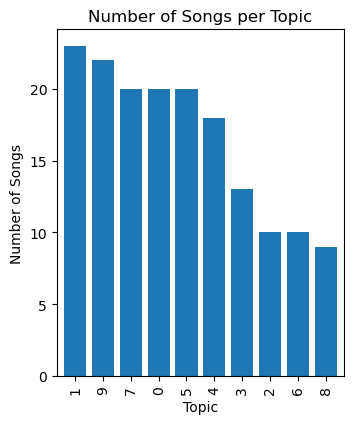

In [75]:
import matplotlib.pyplot as plt

# topic freq distr
topic_distr = lda_theme['Dominant_Topic'].value_counts()

topic_distr.plot(kind='bar', figsize=(3.7,4.5), width=0.8)
plt.xlabel('Topic')
plt.ylabel('Number of Songs')
plt.title('Number of Songs per Topic')

plt.savefig("./static/charts/lda_topic_song_number.png")

plt.show()

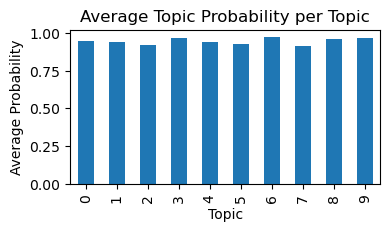

In [46]:
average_topic_prob = lda_theme.groupby('Dominant_Topic')['Topic_Probability'].mean()

average_topic_prob.plot(kind='bar', figsize=(4,2))
plt.xlabel('Topic')
plt.ylabel('Average Probability')
plt.title('Average Topic Probability per Topic')
plt.show()

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

topic_year_trends = lda_theme.groupby(['year', 'Dominant_Topic']).size().unstack(fill_value=0)

topic_year_trends_df = topic_year_trends.reset_index()

# melt the df to long format 
topic_long_df = topic_year_trends_df.melt(id_vars=['year'], var_name='Dominant_Topic', value_name='Number_of_songs')


fig = px.line(
    topic_long_df,
    x='year',
    y='Number_of_songs',
    color='Dominant_Topic',
    title='Topic Trends over Years',
    markers=True
)

# treat x-axis as linear scale
fig.update_xaxes(type='linear', range=[lda_theme['year'].min(), lda_theme['year'].max()])

fig.update_layout(
    legend_title_text='Topic', xaxis_title='Year', yaxis_title='Number of Songs',
    plot_bgcolor='rgb(30, 30, 30)',  # Dark background for the plot area
    paper_bgcolor='rgb(30, 30, 30)',  # Dark background for the entire paper
    font=dict(color='white'),  # White text color
    title=dict(
        font=dict(size=25, color='white')  # White color for the title
    ),
    xaxis=dict(
        showgrid=True,
        gridcolor='rgb(169, 169, 169)',  # Light gridlines
        tickangle=45,
        showline=True,
        linewidth=2,
        linecolor='white'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='rgb(169, 169, 169)',  # Light gridlines
        showline=True,
        linewidth=2,
        linecolor='white'
    ),
    legend=dict(
        font=dict(color='white')  # White legend text
    ), 
    width=830,
    height=400
)

fig.write_html("./static/charts/lda_topic_trend.html")

fig.show()

In [42]:
# Text and topic interpretation
for idx, row in lda_theme[['Dominant_Topic', 'Topic_Words']].drop_duplicates().iterrows():
    print(f"Topic {row['Dominant_Topic']}: {row['Topic_Words']}")

Topic 4: ['love', 'know', 'body', 'touch', 'used']
Topic 7: ['every', 'love', 'day', 'baby', 'want']
Topic 9: ['girls', 'run', 'world', 'know', 'little']
Topic 5: ['somebody', 'love', 'fuck', 'find', 'come']
Topic 3: ['try', 'never', 'get', 'fall', 'meant']
Topic 8: ['go', 'let', 'want', 'need', 'never']
Topic 0: ['star', 'dancing', 'make', 'know', 'money']
Topic 1: ['baby', 'know', 'side', 'rain', 'come']
Topic 6: ['work', 'lose', 'night', 'kiss', 'always']
Topic 2: ['know', 'wake', 'middle', 'good', 'let']



**Heatmap showing the probability of dominant topic for each year from 2014 to 2024**

- It's important to normalize the data to ensure the values represent the relative importance or dominance of eahc topic within that year, regarldess of number of songs. 
- I'll include the song play count into the heatmap to give more weight to the songs that I listened to more often. 
- This will lead to a more accurate refelction of how dominant each topic truly was in my listening habits. 
- calculate weighted probability:
    * sum of play counts for that topic / total play counts for that year 